In [1]:
!pip install pykalman

     |████████████████████████████████| 235kB 5.8MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-cp37-none-any.whl size=48464 sha256=4620a796cc10159660fd4db75f5487a412aed9f06df07eba847f33a94a1b8d00
  Stored in directory: /root/.cache/pip/wheels/d9/e8/6a/553d9832679cb74a8434fa597c3abdb07313e40054a0adf9ac
Successfully built pykalman


In [2]:
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from pykalman import KalmanFilter
from numpy import ma
from matplotlib.patches import Ellipse
from numpy import asarray
from PIL import Image
import numpy as np
import os
import csv

In [3]:
#reading ground truth csv file into a python list
file = open('GT.csv')
csv_reader = csv.reader(file)
#next(csv_reader)
for row in csv_reader:
  GT_data = list(csv_reader)

   # print(row)

print(len(GT_data))

80


In [ ]:
'''
#reading the video frame by frame and save each frame as .jpg file
vidcap = cv2.VideoCapture('tumor.avi')
success,image = vidcap.read()
count = -1
while success:
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
 # print('Read a new frame: ', success)
  count += 1
  '''

'\n#reading the video frame by frame and save each frame as .jpg file\nvidcap = cv2.VideoCapture(\'tumor.avi\')\nsuccess,image = vidcap.read()\ncount = -1\nwhile success:\n  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file      \n  success,image = vidcap.read()\n # print(\'Read a new frame: \', success)\n  count += 1\n  '

In [ ]:
'''
#reading template file
#doing template match(but is not saved)
PNG_DIRECTORY = '/content'


def template_match():

  template = cv2.imread('/content/template-50-2.png', 0)
  height, width = template.shape[::]

  images = []
  for f in os.listdir(PNG_DIRECTORY):
     if f.endswith('.jpg'):
      image_path = os.path.join(PNG_DIRECTORY, f)
      frame = cv2.imread(image_path)
      img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      res = cv2.matchTemplate(img_gray, template, cv2.TM_SQDIFF)
      min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
      top_left = min_loc 
      bottom_right = (top_left[0] + width, top_left[1] + height)
      frame=cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 2)
      #plt.imshow(res, cmap='gray')
     # cv2.imshow("Matched image", frame)
     # cv2.waitKey()
     # cv2.destroyAllWindows()
     # print(image_path)
      f2 = f.split('.')[0]
      #print(int(f2.split('e')[1]))
    
     # f3 = int(f2.split('e')[1])
      #cv2.imwrite("%d.jpg" % f3,image)

      #images.append(f)
  #return(images)

#img_list=template_match()
#print(img_list)
'''

In [ ]:
template_match()

KeyboardInterrupt: ignored

In [4]:
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from pykalman import KalmanFilter
from numpy import ma
from matplotlib.patches import Ellipse
from numpy import asarray
from PIL import Image
import numpy as np


#%%
#upload the files in colab temporary folder before running
#the files needed are: 1-video file and 2-template file

template = cv2.imread('/content/template-50-2.png', 0)
#template = cv2.imread('/content/temp-de.png', 0)
#template = cv2.imread('/content/template-50-painted-grey.png', 0)
w, h = template.shape[::-1]

#f_movie = 'raw_movie.mp4'
#f_movie = 'DE.avi'
f_movie = 'tumor.avi'
def get_streams(f_movie):
    capture = cv2.VideoCapture(f_movie)
    fourcc=capture.get(cv2.CAP_PROP_FOURCC)
    fps=int(capture.get(cv2.CAP_PROP_FPS))
    frameSize=(int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
                int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    numframes = numframes = capture.get(7)

    print("\t Width: ",frameSize[0])
    print("\t Height: ",frameSize[1])
    print("\t FourCC: ",fourcc)
    print("\t Framerate: ",fps)
    print("\t Frames: ", numframes)
    
    out = cv2.VideoWriter('test_track.mp4',
                        cv2.VideoWriter_fourcc(*'MP4V'),
                        fps/10, 
                        frameSize)
    return capture, out

capture, out = get_streams(f_movie)
   

#%%


def get_kalman(observationCov, MarkedMeasure, ax, ay):
        
  Transition_Matrix=[[1,0,1,0],
                    [0,1,0,1],
                    [0,0,1,0],
                    [0,0,0,1]]

  Observation_Matrix=[[1,0,0,0],[0,1,0,0]]

  xinit=ax[0]
  yinit=ay[0]
  vxinit=ax[1]-ax[0]
  vyinit=ay[1]-ay[0]
  initstate=[xinit,yinit,vxinit,vyinit]
  initcovariance=1.0e-3*np.eye(4)
  transistionCov=1.0e-4*np.eye(4)
  observationCov=1.0e-1*np.eye(2)
  kf=KalmanFilter(transition_matrices=Transition_Matrix,
                      observation_matrices =Observation_Matrix,
                      initial_state_mean=initstate,
                      initial_state_covariance=initcovariance,
                      transition_covariance=transistionCov,
                      observation_covariance=observationCov)
  kf = kf.em(MarkedMeasure, n_iter=3)
  kf.em(MarkedMeasure).smooth(MarkedMeasure)
  (filtered_state_means, filtered_state_covariances) = kf.filter(MarkedMeasure)

  return filtered_state_means, filtered_state_covariances

def get_ellipse(cov, s=5.991):
    def eigsorted(cov):
       # print(cov.shape)
        vals, vecs = np.linalg.eigh(cov)

        order = vals.argsort()[::-1]

        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    # I had to take the absolute value here to prevent errors (CRM)
    width, height = (2 * np.sqrt(np.absolute(vals)*s))
    

    return width, height, theta

def plot_cov_ellipse(cov, pos, s=5.991, ax=None, **kwargs):


  if ax is None:
      ax = plt.gca()
  width, height, theta = get_ellipse(cov)
  # plot the ellipse with radius=10 for object
  ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
  # make the ellipse 5 times bigger to be visible,if needed
  #ellip = Ellipse(xy=pos, width=5*width, height=5*height, angle=theta, **kwargs)
  ellip.set_edgecolor('red')
  ellip.set_facecolor('none')
  ax.add_artist(ellip)
  return ellip

def plot_legend(frame,center):
  # add a legend
 # frameSize = (480, 360)
 #for the croped area video the frame size is 128 x 86
 # frameSize = (128, 86)
  frameSize = (1024, 728)

  cv2.circle(frame,
             (frameSize[0]-95, 10),1,(255,0,0), 2)
 # cv2.putText(frame,
 #             'Object Detect',
#             (frameSize[0]-85, 20), 
 #             cv2.FONT_HERSHEY_SIMPLEX,
 #             0.35,
 #             (0,0,250),
 #             1)
 # cv2.circle(frame,
 #            (frameSize[0]-95, 32),
  #           5,
   #          (255,0,0),
   #          1)
  cv2.circle(frame, center,1,(255,0,0),2)
  cv2.putText(frame,'Center', (frameSize[0]-85, 10), cv2.FONT_HERSHEY_SIMPLEX,0.35,(255,0,0),1)

def rt_kalman_tracker(capture, out):
  # Use the last 10 video frames to build the background filter
  #history = 10
 

  # initialize
  numframes = capture.get(7)
  ax = []
  ay = []
  MarkedMeasure = ma.empty([1])
  predx = []
  predy = []
  uncertainty_list = [[ [] for col in range(3)] for row in range(4)]
  count = 0
  min_temp_list=[]
  max_temp_list=[]
  res_temp_list=[]
  dif_list=[]
  j_val_list=[]
  #---entering the first value manualy so that kalman filter works-----
  ax.append(int(GT_data[0][0]))
  ay.append(int(GT_data[0][1]))
  try:
    measured.append([int(GT_data[0][0]),int(GT_data[0][1])])
  except:
    measured = [[int(GT_data[0][0]),int(GT_data[0][1])]]
  try:
    MarkedMeasure=ma.append(MarkedMeasure, [[int(GT_data[0][0]),int(GT_data[0][1])]], 0)
  except:
    MarkedMeasure=ma.asarray(measured)

  while count < numframes-1:
    
    count+=1

    # Capture video frame-by-frame
    _, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame = cv2.equalizeHist(frame)

    res = cv2.matchTemplate(frame, template, cv2.TM_CCORR_NORMED)
    # to restrict the search area:
    #roi = frame[400:600 , 200:500]
    #res = cv2.matchTemplate(roi, template, cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)  
    min_temp_list.append(min_val)
    res_temp_list.append(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    frame=cv2.rectangle(frame,top_left, bottom_right, 255, 2)

    x_cntr_pred=(top_left[0] + w/2)
    y_cntr_pred=(bottom_right[1]-h/2)
    radius = abs(max_loc[0]-min_loc[0])

    x_cntr_tmpl=int(GT_data[count-1][0])
    y_cntr_tmpl=int(GT_data[count-1][1])

    x_dif=abs(x_cntr_tmpl-x_cntr_pred )
    y_dif=abs(y_cntr_tmpl-y_cntr_pred)
    
    #print(y_dif)

    dif_list.append(y_dif)
    #print(dif_list)
   # print(count)
    if x_dif>=50 or y_dif>=50:
      shrd_pix=0
    else:
      shrd_pix=(abs(50-x_dif))*(abs(50-y_dif))

    ttl_pix=2500
    j_val=(shrd_pix/ttl_pix)*100
    j_val_list.append(j_val)

    
    #measured.append([GT_data[0][0], GT_data[0][1]])

   # if y_dif < 100  and x_dif<100:

    if j_val >= 70:
  
   # if(max_val> 0.9987):
  
      print('object detected')
     
      
      x_cntr_pred=(top_left[0] + w/2)
      y_cntr_pred=(bottom_right[1]-h/2)
      radius = abs(max_loc[0]-min_loc[0]) 

      if count > 0:
        ax.append(x_cntr_pred)
        ay.append(y_cntr_pred)
        try:
            measured.append([x_cntr_pred, y_cntr_pred])
        except:
            measured = [[x_cntr_pred,y_cntr_pred]]
        try:
            MarkedMeasure=ma.append(MarkedMeasure, [[x_cntr_pred,y_cntr_pred]], 0)
        except:

            MarkedMeasure=ma.asarray(measured)
        # reset history
        # TODO: This will not working with current result output and plotting tools
           # if not isinstance(MarkedMeasure.mask, np.bool_) and ((MarkedMeasure.mask[-3:]==False).all() and all(MarkedMeasure.mask[-4]==True)):
            #    print('resetting history')
            #    new_start = -3
            #    MarkedMeasure = MarkedMeasure[-3:]
             #   ax = ax[-3:]
             #   ay = ay[-3:]
              #  print(MarkedMeasure)
    
    # if no object is detected used a masked value
    #elif ax :
    else  :
      if len(MarkedMeasure)>2:
        print('no observe')
        #MarkedMeasure=ma.append(MarkedMeasure, [[531,397]], 0) 
        MarkedMeasure[-1]=ma.masked


    # wait until there is some centers in the list
    if len(MarkedMeasure) > 1:
            
        # this is the measurement error matrix
        observationCov=[[0.1, 0],
                        [0, 0.1]]
        observationCov2=[[0.2, 0],
                        [0, 0.2]]
        observationCov3=[[0.3, 0],
                        [0, 0.3]]
        observationCov4=[[0.5, 0],
                        [0, 0.5]]

        obs_cov = [[[0.1, 0],[0, 0.1]], 
                  [[0.2, 0], [0, 0.2]],
                  [[0.3, 0], [0, 0.3]], 
                  [[0.5, 0], [0, 0.5]]]
        

        filtered_state_means, filtered_state_covariances = get_kalman(observationCov, MarkedMeasure, ax, ay)
        
        filt_state_cov = filtered_state_covariances

        predx.append(filtered_state_means[-1, 0])
        predy.append(filtered_state_means[-1, 1])


        center = (int(predx[-1]), int(predy[-1]))
        

        width, height, theta = get_ellipse(filtered_state_covariances[-1][:2,:2])
        uncertainty_list[0][0].append(theta)
        uncertainty_list[0][1].append(width)
        uncertainty_list[0][2].append(height)
        
       
        
        # ellipse is 95% CI about center location so we add the objects radius to 
        # capture whole object
       #axesLength = (int(width/2+radius), int(height/2+radius))
        
        
        fig, ax1 = plt.subplots(1,1)
        plt.title("frame number "+str(count))
       # plt.imshow(frame)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax1.scatter(predx[-1], predy[-1],color='red',marker= 'o')
       # plt.axis('off') 
      
        cv=filt_state_cov[-1][:2,:2]
        mean = (predx[-1],predy[-1])
        ellipse = plot_cov_ellipse(cv, mean, ax=ax1) 

        
        #save plots to make the movie file later
        fname = '%d.png' % count
        plt.savefig(fname)
  
       

   
    # write frame to output stream
    out.write(frame)

    # Display the resulting frame
    #---------------------------------------
    #cv2_imshow(frame)
    
    #saving result frames in jpeg format
    data = asarray(frame)
    Image.fromarray(data).save(str(count)+'.jpeg')
    cv2.waitKey(1000)
  
  # Close down the video stream
  capture.release()
 
  return ax, ay, predx, predy, filtered_state_means, filt_state_cov, uncertainty_list,min_temp_list,dif_list,res_temp_list,j_val_list

ax, ay, predx, predy, filtered_state_means, filt_state_cov, uncertainty_list,min_temp_list,dif_list,res_temp_list,j_val_list = rt_kalman_tracker(capture,out)


#errors = [(0.1, 0.1), (0.2,0.2), (0.3,0.3), (0.5, 0.5)]



plt.tight_layout()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(dif_list)

[74.0, 14.0, 10.0, 6.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 52.0, 3.0, 51.0, 52.0, 246.0, 248.0, 256.0, 12.0, 263.0, 21.0, 24.0, 29.0, 278.0, 36.0, 40.0, 45.0, 49.0, 298.0, 304.0, 109.0, 293.0, 99.0, 39.0, 89.0, 23.0, 20.0, 20.0, 16.0, 12.0, 4.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 1.0, 58.0, 8.0, 66.0, 70.0, 74.0, 75.0, 25.0, 29.0, 33.0, 36.0, 52.0, 52.0, 54.0, 298.0, 53.0, 289.0, 284.0, 279.0, 85.0, 80.0, 75.0, 15.0, 14.0, 10.0, 7.0]


In [ ]:
print(len(j_val_list))

79


In [ ]:
'''
Calculating Jaccard Value:

 1- Count the number of members which are shared between both sets.
    (2500-)
  2-Count the total number of members in both sets (shared and un-shared).
 3- Divide the number of shared members (1) by the total number of members (2).
 4- Multiply the number you found in (3) by 100.

'''


ValueError: ignored

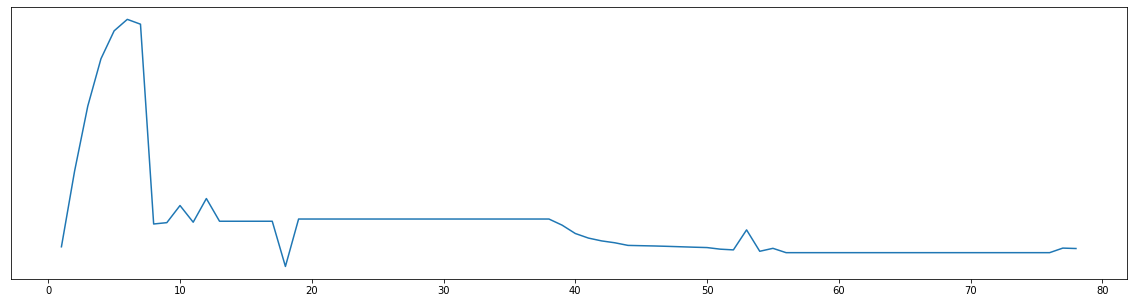

In [13]:

f_num=list(range(1, 79))
plt.rcParams["figure.figsize"] = (20,5)
#plt.plot(f_num, min_temp_list, label = "min ") 
plt.plot(f_num, predx, label = "x predicted") 

plt.plot(f_num, [ x[0] for x in GT_data], label = "x predicted") 
plt.xticks(range(0,80))
'''
The amount for y will be defined by the amount of precision we want.
For example if we want 90% precision, then we calculate this value in this manner:
  0.9 *2500=2250
  2500-2250=250
  250/2=125
  This is the maximum amount of pixel error if we want to have 90% accuracy of positioning.
  We go ahead with this example.

'''
#plt.axhline(y=125, color='r', linestyle='-',label = "90% threshold")
plt.legend() 
plt.show() 

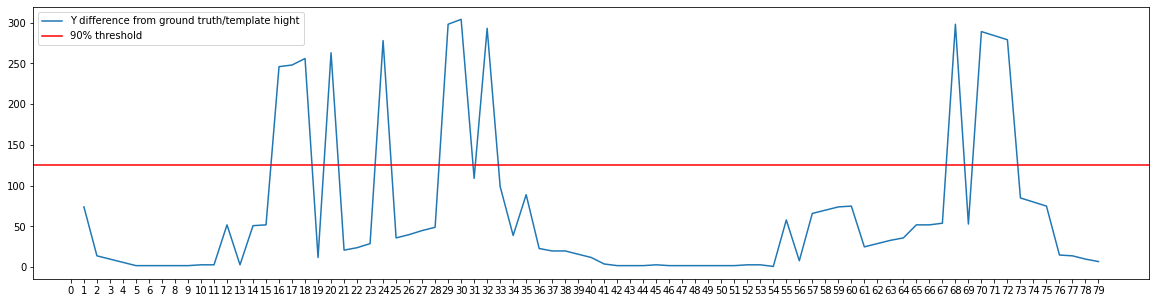

In [ ]:

f_num=list(range(1, 80))
plt.rcParams["figure.figsize"] = (20,5)
#plt.plot(f_num, min_temp_list, label = "min ") 
plt.plot(f_num, dif_list, label = "Y difference from ground truth/template hight") 
plt.xticks(range(0,80))
'''
The amount for y will be defined by the amount of precision we want.
For example if we want 90% precision, then we calculate this value in this manner:
  0.9 *2500=2250
  2500-2250=250
  250/2=125
  This is the maximum amount of pixel error if we want to have 90% accuracy of positioning.
  We go ahead with this example.

'''
plt.axhline(y=125, color='r', linestyle='-',label = "90% threshold")
plt.legend() 
plt.show() 

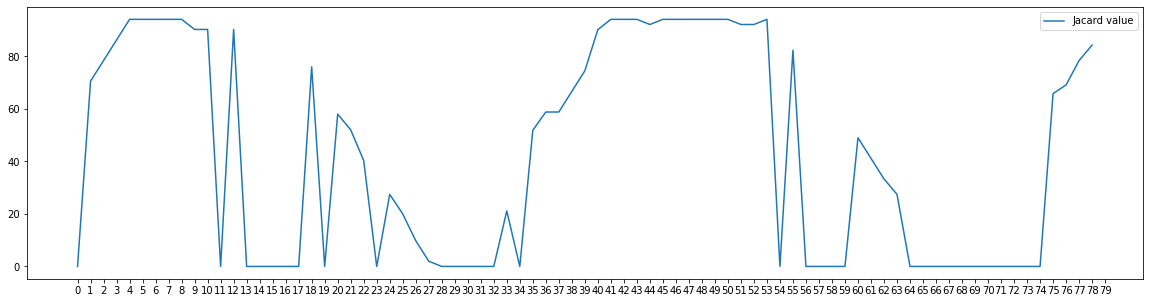

In [14]:
f_num=list(range(0, 79))
plt.rcParams["figure.figsize"] = (20,5)
#plt.plot(f_num, min_temp_list, label = "min ") 
plt.plot(f_num,j_val_list , label = "Jacard value") 
plt.xticks(range(0,80))
'''
  0.9 *2500=2250
  0.8 * 2500= 2000
  0.7 * 2500= 1750

'''
#plt.axhline(y=90, color='r', linestyle='-',label = "90%  similarity threshold")
plt.legend() 
plt.show() 


total number of bad frames:  12

total number of good frames: 67

mean of bad frames:   278.0

mean of good frames:  29.313432835820894

variance of bad frames:   408.3636363636364

variance of good frames:  865.733604703754



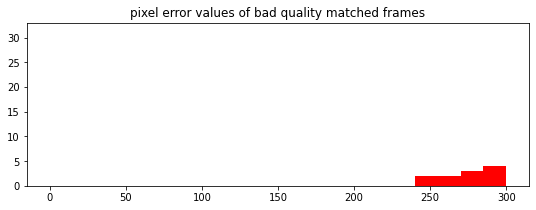

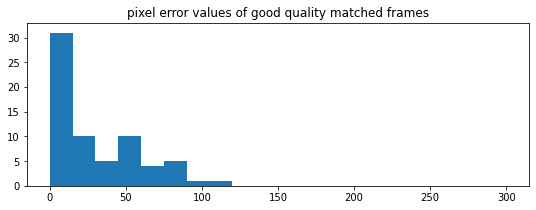

In [ ]:
import statistics 
# res_temp_list: 80(frame) X 719(high) X 975(length)
#len(dif_list[0][0])
count =0
bad_list=[]
bad_match=[]
good_list=[]
good_match=[]
for m in dif_list:
  count+=1
  if m > 125:
    bad_list.append(count)
    bad_match.append(m)
  else:
    good_list.append(count)
    good_match.append(m)

#print(bad_list)
#print number of bad frames
print("\ntotal number of bad frames:  "+str(len(bad_list)))
print("\ntotal number of good frames: "+str(len(good_list)))
#___________________computing mean and variance of these frames quality______________________

bad_mean = statistics.mean(bad_match) 
bad_var=statistics.variance(bad_match)
good_mean = statistics.mean(good_match) 
good_var=statistics.variance(good_match)

print("\nmean of bad frames:   "+ str(bad_mean))
print("\nmean of good frames:  "+ str(good_mean))
print("\nvariance of bad frames:   "+ str(bad_var))
print("\nvariance of good frames:  "+ str(good_var)+"\n")

#-------------------------------------------
plt.rcParams["figure.figsize"] = (9,3)
plt.ylim(0,33)
plt.hist(bad_match, bins = 20,range=(0,300), color="red") 
plt.title("pixel error values of bad quality matched frames") 
plt.show() 
#-----------------------------------------------
#-------------------------------------------
plt.hist(good_match,bins = 20, range=(0,300)) 
plt.ylim(0,33)
plt.title("pixel error values of good quality matched frames") 
plt.show() 


 number of bad frames:  57

 number of good frames: 22

mean of bad frames:   24.2680701754386

mean of good frames:  93.11090909090909

variance of bad frames:   979.3579979949876

variance of good frames:  2.403189610389612



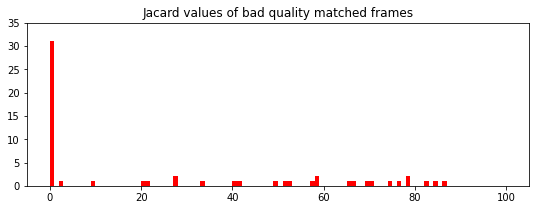

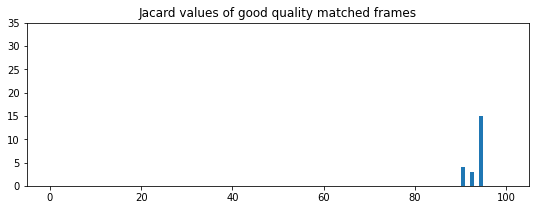

In [ ]:
import statistics 
# res_temp_list: 80(frame) X 719(high) X 975(length)
#len(dif_list[0][0])
count =0
bad_list=[]
bad_match=[]
good_list=[]
good_match=[]
for m in j_val_list:
  count+=1
  if m < 90:
    bad_list.append(count)
    bad_match.append(m)
  else:
    good_list.append(count)
    good_match.append(m)

#print(bad_list)
#print number of bad frames
print("\n number of bad frames:  "+str(len(bad_list)))
print("\n number of good frames: "+str(len(good_list)))
#___________________computing mean and variance of these frames quality______________________

bad_mean = statistics.mean(bad_match) 
bad_var=statistics.variance(bad_match)
good_mean = statistics.mean(good_match) 
good_var=statistics.variance(good_match)

print("\nmean of bad frames:   "+ str(bad_mean))
print("\nmean of good frames:  "+ str(good_mean))
print("\nvariance of bad frames:   "+ str(bad_var))
print("\nvariance of good frames:  "+ str(good_var)+"\n")

#-------------------------------------------
plt.rcParams["figure.figsize"] = (9,3)
plt.ylim(0,35)
plt.hist(bad_match, bins = 100,range=(0,100), color="red") 
plt.title("Jacard values of bad quality matched frames") 
plt.show() 
#-----------------------------------------------
#-------------------------------------------
plt.hist(good_match,bins = 100, range=(0,100)) 
plt.ylim(0,35)
plt.title("Jacard values of good quality matched frames") 
plt.show() 

In [ ]:
'''
#!!------it takes too long to run this code block------!!
# res_temp_list: 80(frame) X 719(high) X 975(length)
len(res_temp_list[0][0])
mean_arr=[]
var_arr=[]

for i in res_temp_list:
  frm_val = i.flatten() 
  frm_val=frm_val.reshape(1,-1)
  #print(frm_val)   
  mean=statistics.mean(frm_val[0][:])
  #print(mean)
  mean_arr.append(mean)
  var = sum((j - mean) ** 2 for j in frm_val[0]) / len(frm_val[0]) 
  #print(var)
  var_arr.append(var)
  '''

'\n#!!------it takes too long to run this code block------!!\n# res_temp_list: 80(frame) X 719(high) X 975(length)\nlen(res_temp_list[0][0])\nmean_arr=[]\nvar_arr=[]\n\nfor i in res_temp_list:\n  frm_val = i.flatten() \n  frm_val=frm_val.reshape(1,-1)\n  #print(frm_val)   \n  mean=statistics.mean(frm_val[0][:])\n  #print(mean)\n  mean_arr.append(mean)\n  var = sum((j - mean) ** 2 for j in frm_val[0]) / len(frm_val[0]) \n  #print(var)\n  var_arr.append(var)\n  '

In [ ]:
'''
#print(mean_arr)
#print(var_arr)

count =0
bd_mean=[]
bd_var=[]
gd_mean=[]
gd_var=[]
for m in bad_list:
  bd_mean.append(mean_arr[m-1])
  bd_var.append(var_arr[m-1])
for n in good_list:
  gd_mean.append(mean_arr[n-1])
  gd_var.append(var_arr[n-1])

#-------------------------------------------
plt.hist(bd_mean,bins = 20, range=(0.97950, 0.97962), color="red") 
plt.ylim(0,12)
plt.rcParams["figure.figsize"] = (10,5)
plt.title("mean values of bad quality matched frames") 
plt.show() 
#-------------------------------------------
plt.hist(gd_mean,bins = 20, range=(0.97950, 0.97962)) 
plt.ylim(0,12)
plt.rcParams["figure.figsize"] = (10,5)
plt.title("mean values of good quality matched frames") 
plt.show() 
'''

'\n#print(mean_arr)\n#print(var_arr)\n\ncount =0\nbd_mean=[]\nbd_var=[]\ngd_mean=[]\ngd_var=[]\nfor m in bad_list:\n  bd_mean.append(mean_arr[m-1])\n  bd_var.append(var_arr[m-1])\nfor n in good_list:\n  gd_mean.append(mean_arr[n-1])\n  gd_var.append(var_arr[n-1])\n\n#-------------------------------------------\nplt.hist(bd_mean,bins = 20, range=(0.97950, 0.97962), color="red") \nplt.ylim(0,12)\nplt.rcParams["figure.figsize"] = (10,5)\nplt.title("mean values of bad quality matched frames") \nplt.show() \n#-------------------------------------------\nplt.hist(gd_mean,bins = 20, range=(0.97950, 0.97962)) \nplt.ylim(0,12)\nplt.rcParams["figure.figsize"] = (10,5)\nplt.title("mean values of good quality matched frames") \nplt.show() \n'

In [ ]:
'''
#-------------------------------------------
plt.rcParams["figure.figsize"] = (10,5)
plt.hist(bd_var,bins = 20, range=(0.000684, 0.000694), color="red") 
plt.ylim(0,12)
plt.title("variance values of bad quality matched frames") 
plt.show() 
#-------------------------------------------
plt.hist(gd_var,bins = 20, range=(0.000684, 0.000694)) 
plt.ylim(0,12)
plt.title("variance values of good quality matched frames") 
plt.show() 
'''

'\n#-------------------------------------------\nplt.rcParams["figure.figsize"] = (10,5)\nplt.hist(bd_var,bins = 20, range=(0.000684, 0.000694), color="red") \nplt.ylim(0,12)\nplt.title("variance values of bad quality matched frames") \nplt.show() \n#-------------------------------------------\nplt.hist(gd_var,bins = 20, range=(0.000684, 0.000694)) \nplt.ylim(0,12)\nplt.title("variance values of good quality matched frames") \nplt.show() \n'

In [ ]:
max(dif_list)
#min(trns_arr)

304.0

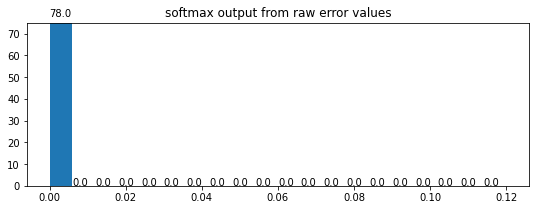


min value after transform:  0.0125
max value after transform:  3.8



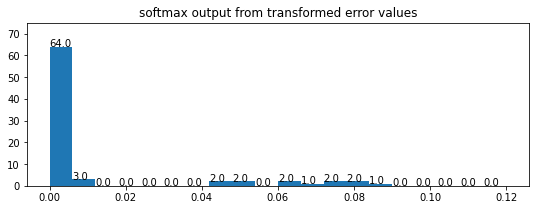

In [ ]:
trnsf_arr=[]
for i in dif_list:
  trnsf_arr.append((i/80))

#---------------------------softmax function---------------------
def softmax(x):
    """Compute softmax values for each sets of values in min_temp_list."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    #return np.exp(x) / np.sum(np.exp(x), axis=0)
softmax_res=softmax(dif_list)


#--------------------------plot-----------------------
ar=plt.hist(softmax_res,bins = 20, range=(0,0.12)) 
plt.title("softmax output from raw error values") 
plt.ylim(0,75)
for i in range(20):
    plt.text(ar[1][i],ar[0][i],str(ar[0][i]))
plt.show() 
#------------------------------------------------------

print("\nmin value after transform:  "+str(min(trnsf_arr)))
print("max value after transform:  "+str(max(trnsf_arr))+"\n")

#print(softmax_res2)

softmax_res2=softmax(trnsf_arr)
arr=plt.hist(softmax_res2,bins = 20, range=(0,0.12)) 
plt.title("softmax output from transformed error values") 
plt.ylim(0,75)
for i in range(20):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

plt.show() 


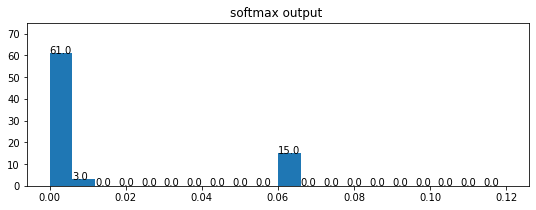


min value after transform:  0.0
max value after transform:  940.8



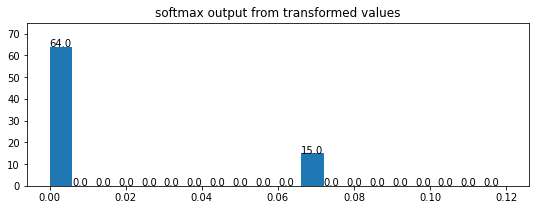

In [ ]:
trnsf_arr=[]
for i in j_val_list:
  trnsf_arr.append((i*10))

#---------------------------softmax function---------------------
def softmax(x):
    """Compute softmax values for each sets of values in min_temp_list."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    #return np.exp(x) / np.sum(np.exp(x), axis=0)
softmax_res=softmax(j_val_list)


#--------------------------plot-----------------------
ar=plt.hist(softmax_res,bins = 20, range=(0,0.12)) 
plt.title("softmax output ") 
plt.ylim(0,75)
for i in range(20):
    plt.text(ar[1][i],ar[0][i],str(ar[0][i]))
plt.show() 
#------------------------------------------------------

print("\nmin value after transform:  "+str(min(trnsf_arr)))
print("max value after transform:  "+str(max(trnsf_arr))+"\n")

#print(softmax_res2)

softmax_res2=softmax(trnsf_arr)
arr=plt.hist(softmax_res2,bins = 20, range=(0,0.12)) 
plt.title("softmax output from transformed values") 
plt.ylim(0,75)
for i in range(20):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

plt.show() 


In [ ]:
binary_trnsf_arr=[]
for i in j_val_list:
  if i>=90:
    binary_trnsf_arr.append(1)
  else:
    binary_trnsf_arr.append(0)

In [ ]:
#----logistic function----------

import numpy as np

from sklearn.linear_model import LogisticRegression


y_test=binary_trnsf_arr

y_train=[]
X_train=list(range(0, 101))
for i in X_train:
  if i<90:
    y_train.append(0)
  else:
    y_train.append(1)

X_test=np.array(j_val_list).reshape(79,-1)
y_train=np.array(y_train).reshape(101, -1)
X_train=np.array(X_train).reshape(101, -1)
#print(X_train)
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[57,  0],
       [ 0, 22]])

In [ ]:
# import required modules for confusion matric
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted frames as 1=good and 0=bad')

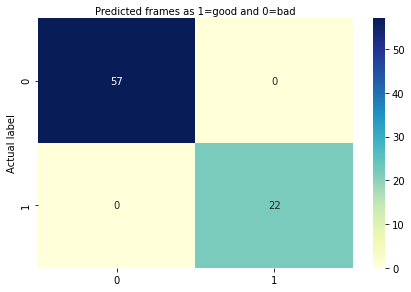

In [ ]:

class_names=["bad","good"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
#plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted frames as 1=good and 0=bad')

In [ ]:



# code for making the output video
# delet the template from folder befor running(since the format is the same as output images) 
import cv2
import os

PNG_DIRECTORY = '/content'

#video_name = 'video.avi'


def write_movie():

  """builds a mp4 video given a directory of .png files"""

  images = []
  for f in os.listdir(PNG_DIRECTORY):
     if f.endswith('.png'):
       images.append(f)
       

  num_images = []
  for img in images:
      new_image = img.split('.')[0]
      num_images.append(new_image)

  num_images.sort(key=int)

  sorted_images = []
  for img in num_images:
      sorted_images.append(img + '.png')

  # Determine the width and height from the first image
  image_path = os.path.join(PNG_DIRECTORY, images[0])
  frame = cv2.imread(image_path)
 # cv2_imshow('video', frame)
  height, width, channels = frame.shape

  # Define the codec and create VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
  out = cv2.VideoWriter('template_match.mp4', fourcc, 8, (width, height))

  for image in sorted_images:
      image_path = os.path.join(PNG_DIRECTORY, image)
      frame = cv2.imread(image_path)

      out.write(frame)  # Write out frame to video

      #cv2.imshow('video', frame)
      if (cv2.waitKey(1) & 0xFF) == ord('q'):  # Hit `q` to exit
          break

  # Release everything if job is finished
  out.release()
  cv2.destroyAllWindows()

write_movie()

In [ ]:
#np.exp(0.775-max(min_temp_list))
